In [ ]:
import numpy as np
from loguru import logger
from glob import glob
import os
import os.path as osp
import mmcv
from avcv.coco import *

import argparse

datasets = [
    ('/data/DMS_Behavior_Detection/Mobile_Cigarret_DB/mobile_cigarette_train_081522_finetuning.json', 
        '/data/DMS_Behavior_Detection/Mobile_Cigarret_DB/', 'mobile-train'), #mobile-train
    ('/data/DMS_Behavior_Detection/Mobile_Cigarret_DB/mobile_cigarette_val_080422.json', 
        '/data/DMS_Behavior_Detection/Mobile_Cigarret_DB/', 'mobile-val'), # mobile-val
    ('/data/DMS_Behavior_Detection/annotations/cvat_train_27_10_2022.json', '/data/DMS_Behavior_Detection/images/', 'cvat-food-train'),
    ('/data/public/coco/annotations/instances_train2017.json', '/data/public/coco/train2017/', 'coco-food-train'),
    ('/data/public/coco/annotations/instances_val2017.json', '/data/public/coco/val2017/', 'coco-food-val'),
]
new_root_dir = '/data/DMS_Behavior_Detection/annotations/'
new_img_dir = '/data/DMS_Behavior_Detection/images/'
mmcv.mkdir_or_exist(new_root_dir)

cats = []
for ann, _,_ in datasets:
    for cat in mmcv.load(ann)['categories']:
        cats.append(cat['name'])

print(sorted(set(cats)))

['airplane', 'apple', 'backpack', 'banana', 'baseball bat', 'baseball glove', 'bear', 'bed', 'bench', 'bicycle', 'bird', 'boat', 'book', 'bottle', 'bowl', 'broccoli', 'bus', 'cake', 'car', 'carrot', 'cat', 'cell phone', 'chair', 'cigarette', 'clock', 'couch', 'cow', 'cup', 'dining table', 'dog', 'donut', 'elephant', 'fire hydrant', 'food/drink', 'fork', 'frisbee', 'giraffe', 'hair drier', 'handbag', 'horse', 'hot dog', 'keyboard', 'kite', 'knife', 'laptop', 'microwave', 'motorcycle', 'mouse', 'orange', 'oven', 'parking meter', 'person', 'phone', 'pizza', 'potted plant', 'refrigerator', 'remote', 'sandwich', 'scissors', 'sheep', 'sink', 'skateboard', 'skis', 'snowboard', 'spoon', 'sports ball', 'stop sign', 'suitcase', 'surfboard', 'teddy bear', 'tennis racket', 'tie', 'toaster', 'toilet', 'toothbrush', 'traffic light', 'train', 'truck', 'tv', 'umbrella', 'vase', 'wine glass', 'zebra']


In [ ]:
category_old_to_new = {
    'cigarette':'cigarette',
    'food/drink':'food/drink',
    'phone':'phone',
    'cell phone': 'phone',
    'banana':'food/drink',
    'apple':'food/drink',
    'sandwich':'food/drink',
    'orange':'food/drink',
    'broccoli':'food/drink',
    'carrot':'food/drink',
    'hot dog':'food/drink',
    'pizza':'food/drink',
    'donut':'food/drink',
    'cake':'food/drink',
    # 'left_eye':'left_eye',
    # 'right_eye':'right_eye',
    # 'mouth':'mouth',
    # 'face':'face'
}

# categories = []
# used_names = set()
# for id, name in enumerate(category_old_to_new.values()):
#     if not name in used_names:
#         categories += [{'id':id+1, 'name':name} ]
#         used_names.add(name)
    
name2cat = {cat:i+1 for i,cat in enumerate(['phone', 'cigarette', 'food/drink'])}
categories = [{'id':i, 'name':name} for name, i in name2cat.items()]
categories

[{'id': 1, 'name': 'phone'},
 {'id': 2, 'name': 'cigarette'},
 {'id': 3, 'name': 'food/drink'}]

In [ ]:
name2cat

{'phone': 1, 'cigarette': 2, 'food/drink': 3}

In [ ]:
from avcv.all import *
out_dict = dict(
    images=[],
    annotations=[],
    categories=categories,
)
for json, img_dir, dname in datasets:
    cc = CocoDataset(json, img_dir)
    for img_id in cc.img_ids:
        img = cc.gt.imgs[img_id].copy()
        anns = cc.gt.imgToAnns[img_id]
        
        new_img_id = len(out_dict['images'])
        

        take = False
        for ann in anns:
            ann = ann.copy()
            ann['image_id'] = new_img_id
            old_cat_name = cc.gt.cats[ann['category_id']]['name']
            # Only wanted old class will be taken
            if old_cat_name in category_old_to_new:
                new_cat_name = category_old_to_new[old_cat_name]
                ann['category_id'] = name2cat[new_cat_name]
                ann['id'] = len(out_dict['annotations'])
                ann['area'] = ann['bbox'][2]*ann['bbox'][3]
                out_dict['annotations'].append(ann)
                take = True
        if take:
            new_img = dict()
            new_img['id'] = new_img_id
            new_img['dataset_name'] = dname
            abs_file_name = os.path.abspath(osp.join(cc.img_dir, img['file_name']))
            new_img['width'], new_img['height'] = Image.open(abs_file_name).size
            rel_path = os.path.relpath(abs_file_name, new_img_dir)
            new_img['file_name'] = rel_path

            
            out_dict['images'].append(new_img)        
len(out_dict['images'])

41845

In [ ]:
mmcv.dump(out_dict, '/data/DMS_Behavior_Detection/annotations/train_3class_phone_cigarette_food_with_coco.json')
newcc = CocoDataset('/data/DMS_Behavior_Detection/annotations/train_3class_phone_cigarette_food_with_coco.json')

In [ ]:
out_dict['images'] = newcc.gt.loadImgs(newcc.gt.imgToAnns.keys())
len(out_dict['images'])

41845

In [ ]:
# out_dict['images'] = newcc.gt.loadImgs(newcc.gt.imgToAnns.keys())
# len(out_dict['images'])

41276

2022-09-29 17:42:00.093 | INFO     | avcv.coco:visualize:190 - Random visualize img_id=26270
2022-09-29 17:42:00.109 | INFO     | avcv.coco:visualize:190 - Random visualize img_id=30279
2022-09-29 17:42:00.121 | INFO     | avcv.coco:visualize:190 - Random visualize img_id=5278
2022-09-29 17:42:00.144 | INFO     | avcv.coco:visualize:190 - Random visualize img_id=10548
2022-09-29 17:42:00.166 | INFO     | avcv.visualize:plot_images:30 - Grid size: (2, 2)


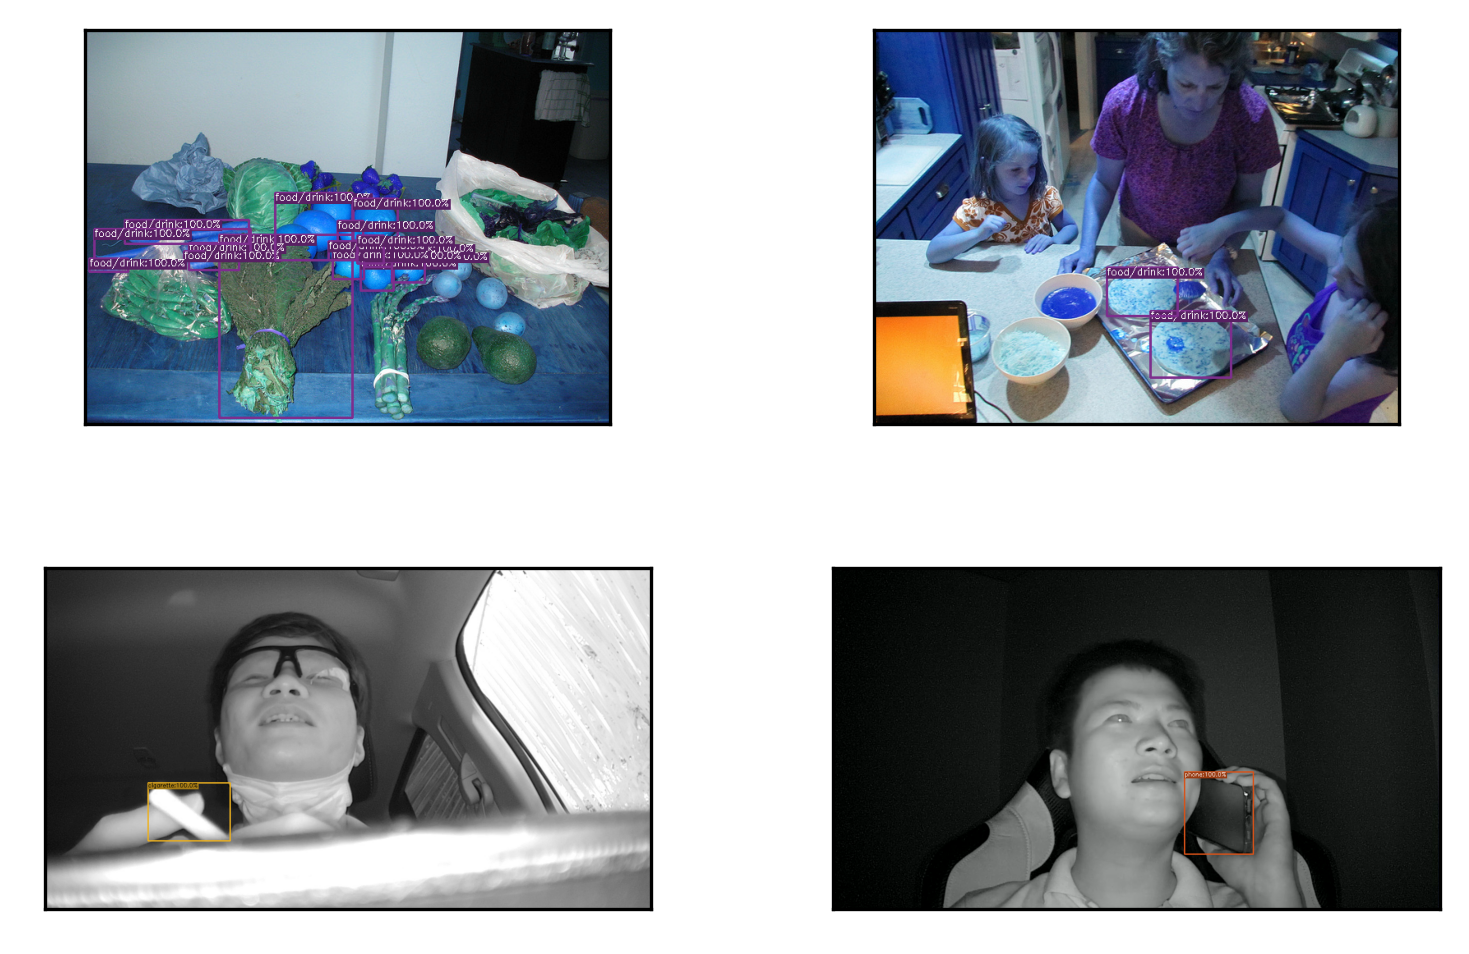

2022-09-29 17:42:00.934 | INFO     | avcv.coco:visualize:190 - Random visualize img_id=24660
2022-09-29 17:42:00.950 | INFO     | avcv.coco:visualize:190 - Random visualize img_id=11349
2022-09-29 17:42:00.980 | INFO     | avcv.coco:visualize:190 - Random visualize img_id=12014
2022-09-29 17:42:01.008 | INFO     | avcv.coco:visualize:190 - Random visualize img_id=8862
2022-09-29 17:42:01.019 | INFO     | avcv.visualize:plot_images:30 - Grid size: (2, 2)


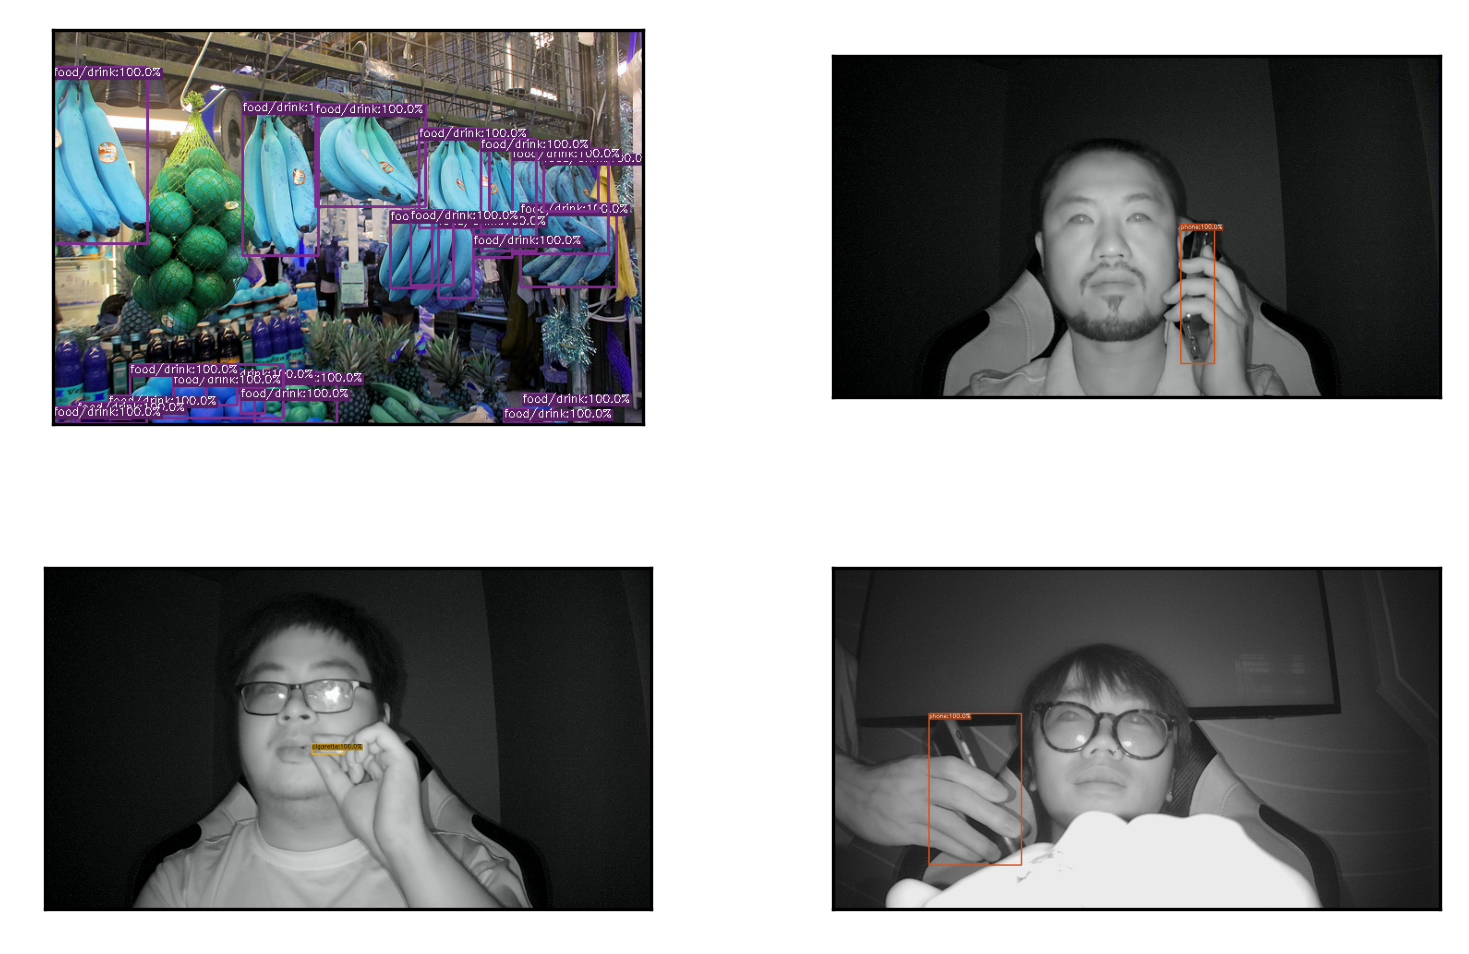

2022-09-29 17:42:01.786 | INFO     | avcv.coco:visualize:190 - Random visualize img_id=11543
2022-09-29 17:42:01.817 | INFO     | avcv.coco:visualize:190 - Random visualize img_id=2476
2022-09-29 17:42:01.847 | INFO     | avcv.coco:visualize:190 - Random visualize img_id=1903
2022-09-29 17:42:01.873 | INFO     | avcv.coco:visualize:190 - Random visualize img_id=15723
2022-09-29 17:42:01.896 | INFO     | avcv.visualize:plot_images:30 - Grid size: (2, 2)


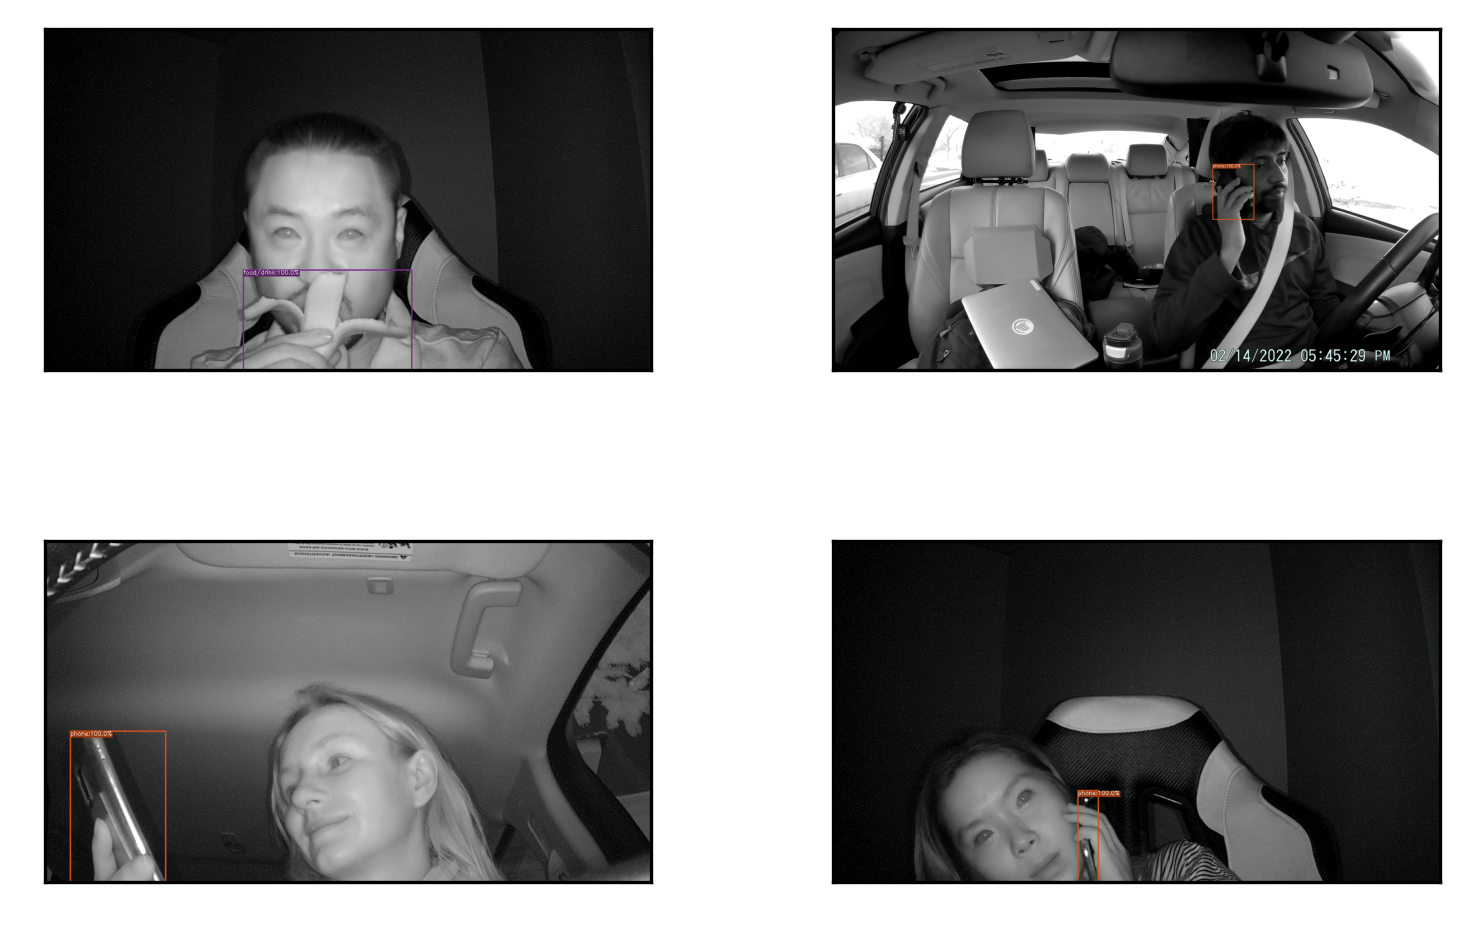

2022-09-29 17:42:02.826 | INFO     | avcv.coco:visualize:190 - Random visualize img_id=1555
2022-09-29 17:42:02.852 | INFO     | avcv.coco:visualize:190 - Random visualize img_id=2531
2022-09-29 17:42:02.879 | INFO     | avcv.coco:visualize:190 - Random visualize img_id=34784
2022-09-29 17:42:02.890 | INFO     | avcv.coco:visualize:190 - Random visualize img_id=415
2022-09-29 17:42:02.908 | INFO     | avcv.visualize:plot_images:30 - Grid size: (2, 2)


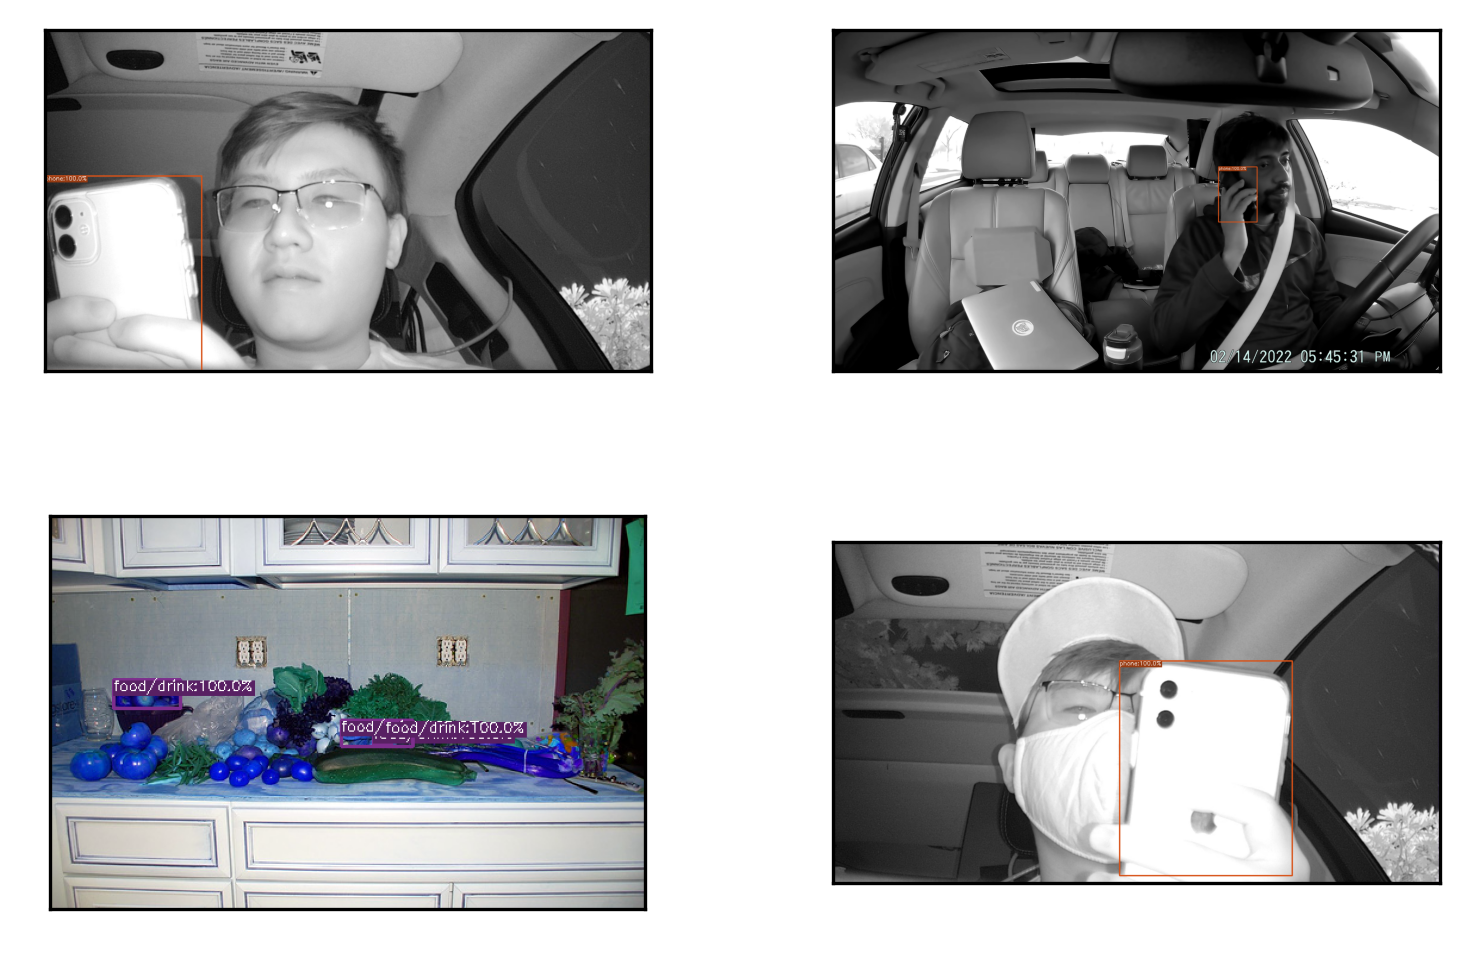

2022-09-29 17:42:03.780 | INFO     | avcv.coco:visualize:190 - Random visualize img_id=36081
2022-09-29 17:42:03.794 | INFO     | avcv.coco:visualize:190 - Random visualize img_id=9749
2022-09-29 17:42:03.815 | INFO     | avcv.coco:visualize:190 - Random visualize img_id=8003
2022-09-29 17:42:03.836 | INFO     | avcv.coco:visualize:190 - Random visualize img_id=32762
2022-09-29 17:42:03.845 | INFO     | avcv.visualize:plot_images:30 - Grid size: (2, 2)


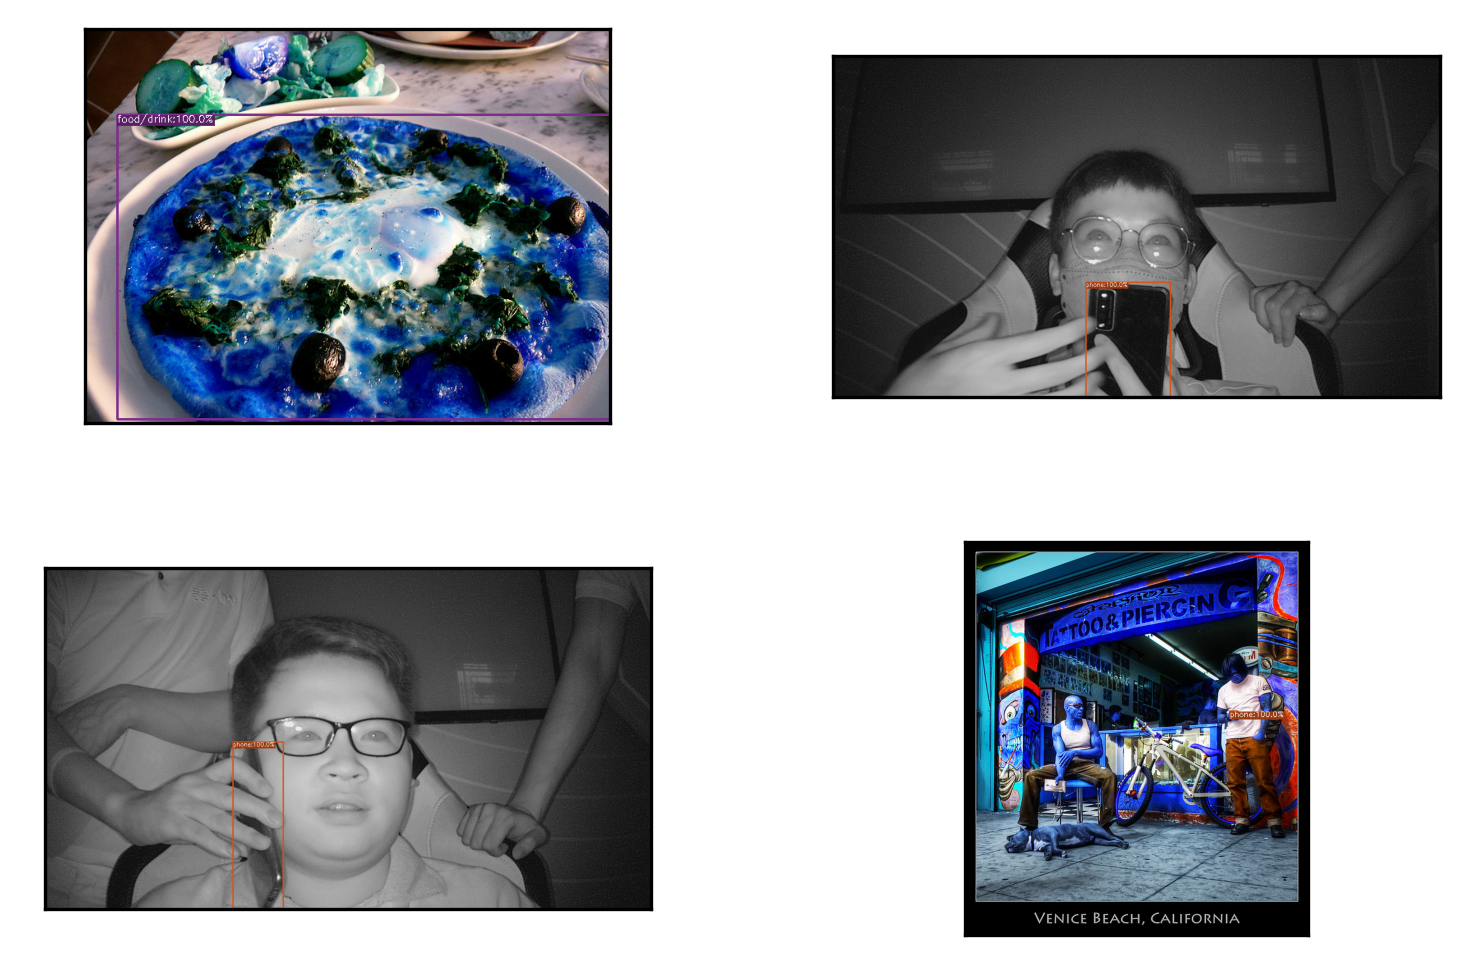

In [ ]:
vis_imgs = []
for i in range(20):
    vis_imgs.append(newcc.visualize(show=0))
    if len(vis_imgs) == 4:
        plot_images(vis_imgs)
        vis_imgs = []

In [ ]:
# mmcv.load('/data/DMS_Behavior_Detection/annotations/train_3class_phone_cigarette_food_with_coco.json')['categories']

In [ ]:
# mmcv.load('/data/DMS_Behavior_Detection/annotations/train_3class_phone_cigarette_food.json')['categories']

In [ ]:
# mmcv.load('/data/public/coco/annotations/instances_val2017.json')['categories']